In [1]:
# Import statements for connecting to google cloud. This should give you a link
# for authentication. Click on the link and sign in with your google account
# that is connected to the google bucket containing your data.
from google.colab import auth
from google.cloud import storage
auth.authenticate_user()

# First, we need to set our project. Replace the assignments below with the
# project ID and bucket name to access for your data.
project_id = 'humanitarian-tent'
bucket_name = 'tent-bucket'
!gcloud config set project {project_id}
client = storage.Client(project_id)
bucket = client.get_bucket(bucket_name)

Updated property [core/project].


# 5. Ground Truth Evaluation for Object Detection

In [2]:
# The '!' commands execute on the machine, so this will install all the required
# dependencies for training your model. For this project, we will be using the
# mxnet platform (https://mxnet.apache.org/) for learning and the gluoncv
# (https://gluon-cv.mxnet.io/) which is a toolkit for computer vision on mxnet. 
!pip install mxnet>=1.3.0 --upgrade
!pip install gluoncv --upgrade

# Other libraries we will be using
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz
import datetime 
import os
import tensorflow as tf
import pickle

spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 0.0.1a1 has requirement requests~=2.18.0, but you'll have requests 2.20.1 which is incompatible.
    100% |████████████████████████████████| 245kB 12.0MB/s 


## Load the Humanitarian Structure Dataset

Since all of our data is store in tfrecord format on the cloud, we have to go through a few steps to convert it to the necessary format to run with Gluon/MXNET.

Here, we first download all of the tfrecord files locally (they are in binary/compressed format so it should take max 1 minute, even for the larger datasets).

Then, we use a custom class (TFRecordFileDataset) to extract the images and labels (bounding boxes + labels) in the compatible format for modeling with Gluon. The dataset that this class wraps can then be used directly as input in to training.


In [3]:
# Note that these file directories are based on the STEP 3: TFRecord Conversion
# notebook. If you wrote your tfrecords in to different file directories please
# replace all the paths below with your custom filepaths.

TF_RECORD_PREFIX = 'tf_records_100'
IM_SIZE = 100
REGION = 'Africa2'
TEST_FILES = ['%s/%s/test.tfrecord-0000%d-of-00010' % (
    TF_RECORD_PREFIX, REGION, i) for i in range(10)]

def to_local(fp):
  """
  Simple mapping function to simplify nested filepaths in the google bucket
  """
  return '_'.join(fp.split('/'))

def upload_files(bucket, files, mapping_fn=to_local):
  """
  This function will take a list of files in a google bucket and upload them
  locally using a simple linearizing mapping function (default is to_local)
  """
  for f in files:
    blob = bucket.get_blob(f)
    with open(mapping_fn(f), 'wb') as obj:
      blob.download_to_file(obj)
    print("Finished %s" % f)

# Upload all TFRecord files locally so we have access to them for training
upload_files(bucket, TEST_FILES)
local_test_files = [to_local(f) for f in TEST_FILES]

Finished tf_records_100/Africa2/test.tfrecord-00000-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00001-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00002-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00003-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00004-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00005-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00006-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00007-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00008-of-00010
Finished tf_records_100/Africa2/test.tfrecord-00009-of-00010


In [0]:
from PIL import Image
from io import BytesIO

classes_dict = {
  b'UNHCR Tent': 0,
  b'Administrative Structure': 1,
  b'Other Tent': 2,
  b'Round Earthen Structure': 3
}
class TFRecordDataset(mx.gluon.data.Dataset):
  """A dataset wrapping over a TFRecord Dataset.

  Each sample is a string representing the raw content of an record.
  Parsing and other formatting logic occurs on each __get_item__ call runtime.

  Parameters
  ----------
  ds : TFDataset with all the data in question
  use_classes: Whether to use the class types for labels or combine them all in
       to a single class
  """
  def __init__(self, ds, use_classes=False):
    self._record = []
    self.use_classes = use_classes
    iterator = ds.make_one_shot_iterator()
    example = iterator.get_next()
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      try:
        while(True):
          result = tf.train.Example.FromString(sess.run(example))
          image_data = result.features.feature['image/encoded'].bytes_list.value[0]
          im = np.frombuffer(image_data, dtype=np.uint8)
          self._record.append(result)
      except tf.errors.OutOfRangeError:
        pass

  def __getitem__(self, idx):
    """
    In this method we overwrite the default index function to take our stored
    binary TFExample representation of the example and extract relevant
    features/labels. Our TFExample should include the encoded image under the
    key 'image/encoded'for a bytes_list and the x and y positions (not
    normalized) of each structure encoded under the keys 'image/object/point/x'
    and 'image/object/point/y' respectively for an int64_list.
    If use_classes was set to True on initialization, this function also expects
    the class value (defined in classes_dict) under the key
    'image/object/class/text' for a bytes_list.
    """
    result = self._record[idx]
    image_data = result.features.feature['image/encoded'].bytes_list.value[0]
    im = np.frombuffer(image_data, dtype=np.uint8)
    im = mx.nd.array(im).reshape((IM_SIZE, IM_SIZE, 3))
    x = np.array(
        result.features.feature['image/object/point/x'].int64_list.value)
    y = np.array(
        result.features.feature['image/object/point/y'].int64_list.value)
    if self.use_classes:
      classes = np.array(
          [classes_dict[x] for x in result.features.feature[
              'image/object/class/text'].bytes_list.value])
    else:
      classes = np.zeros_like(x)
    if x.size > 0:
      label = np.stack(
          [x-10, y-10, x+10, y+10, classes], axis=1).astype(np.float32)
    else:
      label = np.empty((0,5))
    return im, label

  def __len__(self):
      return len(self._record)

In [0]:
def show_examples(net, dataset, num_examples=1,
                  threshold=0.5, fn=lambda x,y,z:(x[0],y[0],z[0])):
  """
  This method is a simple visualization of a variable number of examples from
  two different datasets (recommended for train/validation comparison). This
  function will randomly select num_examples from the two datasets and run the
  net over the examples. It will then display:
  1) example from the first dataset with labels
  2) example from the first dataset with predictions
  3) example from the second dataset with labels
  4) example from the second dataset with predictions
  The function also supports a variable threshold for displaying prediction
  boxes from the net and a lambda conversion function to further manipulate the
  raw output predictions from the net before visualization.
  """

  fig, axes = plt.subplots(num_examples, 2, figsize=(4*2, 4*num_examples))
  
  for i in range(num_examples):
    # Run inference over an example
    image, label = dataset[np.random.randint(len(dataset))]
    x, image = gcv.data.transforms.presets.ssd.transform_test(image, IM_SIZE)
    cid, score, bbox = net(x)
    if fn is not None:
      bbox, score, cid = fn(bbox, score, cid)

    _ = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5],
                      class_names=classes, ax=axes[i, 0])
    _ = viz.plot_bbox(image, bbox, score, cid, class_names=classes,
                      ax=axes[i, 1], thresh=threshold)
    axes[i, 0].axis('off')
    axes[i, 0].title.set_text('Original')
    axes[i, 1].axis('off')
    axes[i, 1].title.set_text('Predicted')
  
  plt.show()

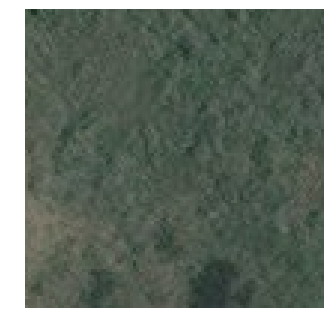

In [9]:
TF_RANDOM_SEED = 325 # For CS325B!
TF_BUFFER_SZ = 256

test_ds = tf.data.TFRecordDataset(local_test_files).shuffle(
    buffer_size=TF_BUFFER_SZ, seed=TF_RANDOM_SEED)
test_dataset = TFRecordDataset(test_ds)

classes = ['tent']  # only one foreground class here
# Uncomment below if you are visualizing and creating classes in the dataset
# classes = [x.decode() for x in list(classes_dict.keys())]

# Retrieve an example and display the image and label
image, label = test_dataset[0]
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5],
                   class_names=classes)
plt.axis('off')
plt.show()

## Check TFRecord Ordering

Since we ran other models for which we want to use the same evaluation, we used a fixed random seed for the TF Record dataset to ensure that we could run inference on the same random examples we rated. In this case, we used a seed of 325 (for CS325B) and took the first 300 entries for the test dataset for rating (100 per group member). Here we ensure that the dataset constructed from MXnet has examples that match the ordering of the TF Dataset object.

In [0]:
featdef = {
    'image/encoded': tf.FixedLenFeature(shape=[], dtype=tf.string),
}

def _parse_image(example_proto, debug=None):
  """Parse a single record into image"""
  example = tf.parse_single_example(example_proto, featdef)
  im = tf.decode_raw(example['image/encoded'], tf.uint8)
  im = tf.cast(im, dtype=tf.float32)
  im = tf.reshape(im, (IM_SIZE, IM_SIZE, 3))
  return im

In [0]:
def check_tfrecord_order(tfrecord_dataset, dataset, N=10):
  iterator = tfrecord_dataset.make_one_shot_iterator()
  example = iterator.get_next()
  results = []
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    try:
      while(len(results) < N):
        # Uncomment below if you want to see both images processed in the same
        # way. Because there are some differences in the way in normalization,
        # images will be the same but rendered slightly differently
#         result = tf.train.Example.FromString(sess.run(example))
#         image_data = result.features.feature['image/encoded'].bytes_list.value[0]
#         im = np.frombuffer(image_data, dtype=np.uint8)
#         output = np.array(im).reshape((IM_SIZE, IM_SIZE, 3))
        output = sess.run(example)
        if len(output.shape) == 4:
          extension = min(N-len(results), output.shape[0])
          for i in range(extension):
            results.append(output[i])
        else:
          results.append(output)
    except tf.errors.OutOfRangeError:
      pass
  for i in range(N):
    fig, axes = plt.subplots(1, 2, figsize=(4*2, 4))
    axes[0].imshow(results[i])
    image, label = dataset[i]
    ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5],
                       class_names=classes, ax=axes[1])
    axes[0].grid('off')
    axes[1].grid('off')
    plt.show()

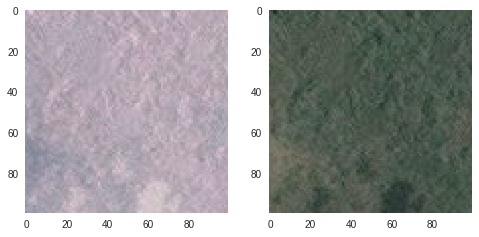

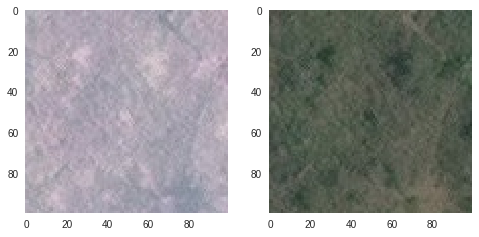

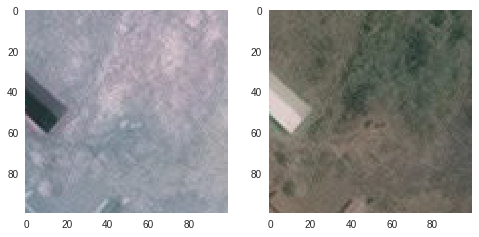

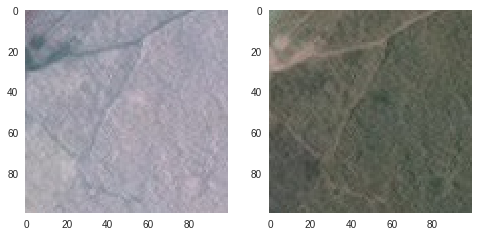

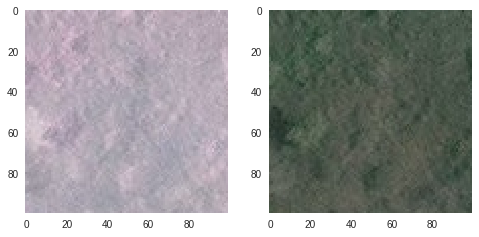

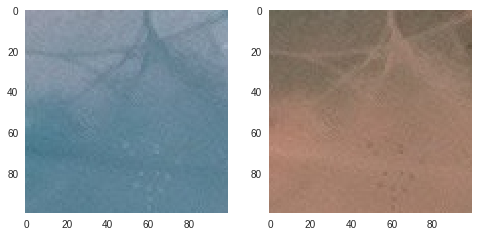

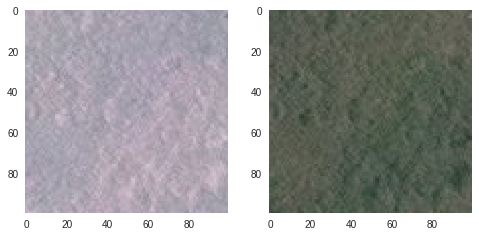

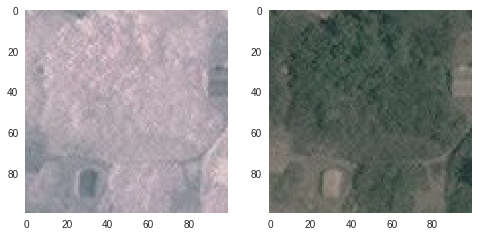

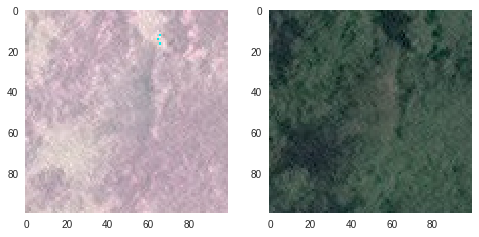

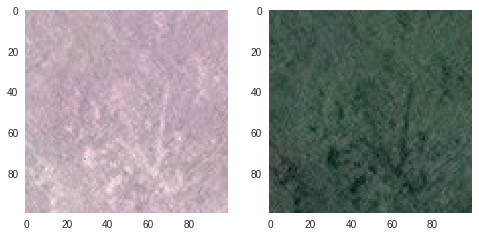

In [14]:
# Construct a dataset in the exact same way as our test dataset input and check
# that both images are of the same example
tfrecord_dataset = tf.data.TFRecordDataset(
    local_test_files).map(_parse_image).shuffle(buffer_size=256, seed=325).batch(8)
check_tfrecord_order(tfrecord_dataset, test_dataset)

## Load Object Detection Model

In [0]:
MODEL = 'ssd_512_resnet50_v1_voc'

# USE THESE FINAL MODELS!
# dan_models/20181130/ssd_512_resnet50_v1_Africa1.params
# dan_models/20181201/ssd_512_resnet50_v1_Africa2.params,
# dan_models/20181126/ssd_512_resnet50_v1_WesternAsia.params.params

MODEL_FILE = 'dan_models/20181201/ssd_512_resnet50_v1_Africa2.params'
net = gcv.model_zoo.get_model(MODEL.replace('voc', 'custom'), classes=classes, pretrained_base=False)
blob = bucket.blob(MODEL_FILE)
blob.download_to_filename('tmp.params')
net.load_parameters('tmp.params')

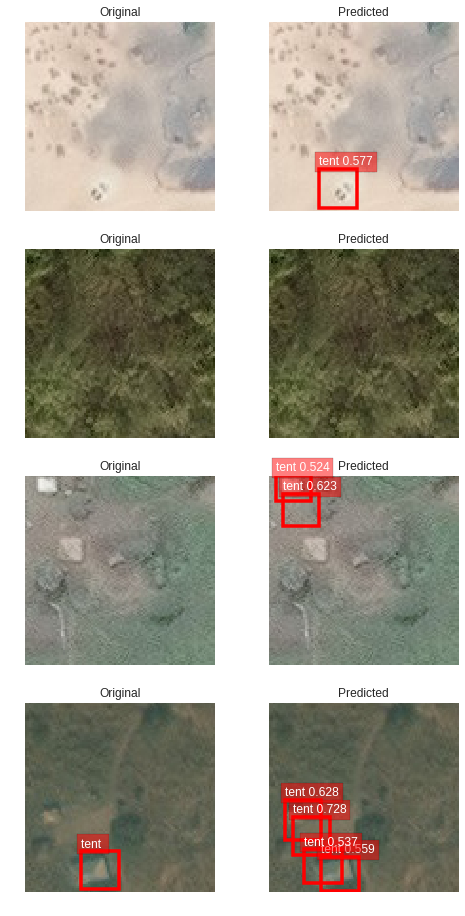

In [21]:
show_examples(net, test_dataset, num_examples=4, threshold=0.5)

## Bounding Box Consolidation

We noticed that in some cases, the model predicted multiple bounding boxes that were very close together. Since all of our labels have fixed bounding box sizes, in cases such as larger buildings the model is incentivized to place multiple boxes to cover the object space. Let's try to address this by iteratively merging bounding boxes that are close together. We do this using some threshold of intersection over union (IOU) and a crude algorithm that loops over all the examples and iteratively merges boxes with IOUs over our desired threshold.

In [0]:
import pandas as pd

def filter_bboxes(bboxes, scores, cids, threshold=0.5):
  """
  This is a simple function that takes in lists of bounding boxes and their
  correpsonding scores, classes, and the threshold of score to filter at and
  returns a filtered list of the stacked bboxes, scores, and cids (N x 6). It
  also removes duplicate bounding boxes and sets the resulting score to be the
  mean of the duplicates
  """
  coord = ['x_min', 'y_min', 'x_max', 'y_max']
  df = pd.DataFrame(data=np.hstack([bboxes.asnumpy(), scores.asnumpy(),
                                    cids.asnumpy()]),
                    columns=coord + ['score', 'cid'])
  grouped = df.groupby(coord).mean().reset_index()
  return grouped[grouped.score > threshold].values

In [0]:
def iou(bbox1, bbox2):
  """
  This is a simple function that takes two bboxes (1x4 ndarrays) and calculates
  the intersection over union (IOU) between these two boxes.
  """
  stacked = np.vstack([bbox1,bbox2])
  x_min_in, y_min_in, x_max_out, y_max_out = np.max(stacked, axis=0)
  x_min_out, y_min_out, x_max_in, y_max_in = np.min(stacked, axis=0)
  intersection = abs((x_max_in-x_min_in)*(y_max_in-y_min_in))
  union = abs((x_max_out-x_min_out)*(y_max_out-y_min_out))
  return intersection/union

In [0]:
def merge_bboxes(arr, threshold=0.5, max_it=100, debug=False):
  """
  This function takes an array of bounding boxes and a threshold for minimum
  IOU for which to merge boxes. It then calculates IOU for every
  pair in the list and merges two boxes together if their IOU exceeds the
  threshold. It iterates this algorithm on all merged boxes until either max_it
  is reached or there are no more boxes to be merged.
  """
  it = 0
  while it < max_it:
    it += 1
    merged_pairs = []
    static = True
    for i in range(len(arr)):
      for j in range(i+1, len(arr)):
        ratio = iou(arr[i][:4], arr[j][:4])
        if debug:
          print("Ratio for %d, %d is %.2f" % (i,j,ratio))
        if ratio > threshold:
          if debug:
            print("Merging indices %d and %d with overlap of %0.2f" % (i, j, ratio))
          merged_pairs.append([i,j])
          # We merged a pair, so this is no longer static
          static = False
    # If nothing was merged/changed, break 
    if static:
      if debug:
        print("Nothing changed! breaking")
      break
    # Remove all boxes that need to be merged together
    to_remove = np.asarray(merged_pairs).flatten()
    merged = [arr[i] for i in range(len(arr)) if i not in to_remove]
    if debug:
      print("New array is:")
      print(merged)
    # Find all connected components of the merged pairs so we know what to group
    components = [] # list of sets containing all the components
    for pair in merged_pairs:
      added = False
      for c in components:
        if pair[0] in c or pair[1] in c:
          c.add(pair[0])
          c.add(pair[1])
          added = True
          break
      if not added:
        components.append(set(pair)) # Create new component
    if debug:
      print("connected components are ")
      print(components)
    # Add all merged components back to our array
    for c in components:
      # Get corresponding box coordinates
      boxes = np.array([arr[idx] for idx in c])
      x_min, y_min = np.min(boxes[:,:2], axis=0)
      x_max, y_max = np.max(boxes[:,2:4], axis=0)
      if debug:
        print("New merged point:")
        print([x_min, y_min, x_max, y_max])
      merged.append(np.append([x_min, y_min, x_max, y_max], np.mean(boxes[:,4:], axis=0)))
    arr = merged
    if debug:
      print("New array has %d boxes" % len(arr))
  return np.asarray(arr)


In [0]:
def filter_and_merge_bboxes(bbox, score, cid, filter_threshold=0.5,
                            iou_threshold=0.5):
  """
  This function takes the raw prediction results from the objection detection
  MXNet and applies the filtering/merging based on specified thresholds.
  It returns the resulting bboxes, scores, and CIDs.
  """
  result = merge_bboxes(
    filter_bboxes(bbox[0], score[0], cid[0], threshold=filter_threshold),
      threshold=iou_threshold, max_it=1)
  return result[:,:4], result[:,4:5], result[:,5:]

In [0]:
def filter_and_merge_fn(filter_threshold=0.5, iou_threshold=0.5):
  """
  This function returns the lambda function for filtering and merging based
  on specified score and IOU threhsolds.
  """
  return lambda x,y,z: filter_and_merge_bboxes(
      x, y, z, filter_threshold=filter_threshold, iou_threshold=iou_threshold)

### Qualitative Check

Let's now try to use our new show_examples function add on which will create bounding boxes

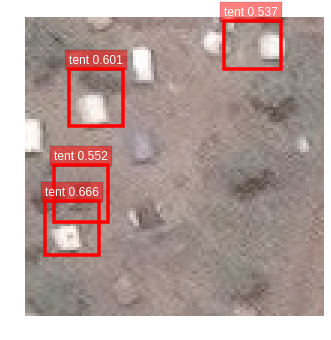

In [73]:
image, label = test_dataset[345]
x, image = gcv.data.transforms.presets.ssd.transform_test(image, IM_SIZE)
cid, score, bbox = net(x)
_bbox, _score, _cid = filter_and_merge_fn(0.5, 0.5)(bbox, score, cid)
viz.plot_bbox(image, _bbox, _score, _cid, class_names=classes)
plt.axis('off');

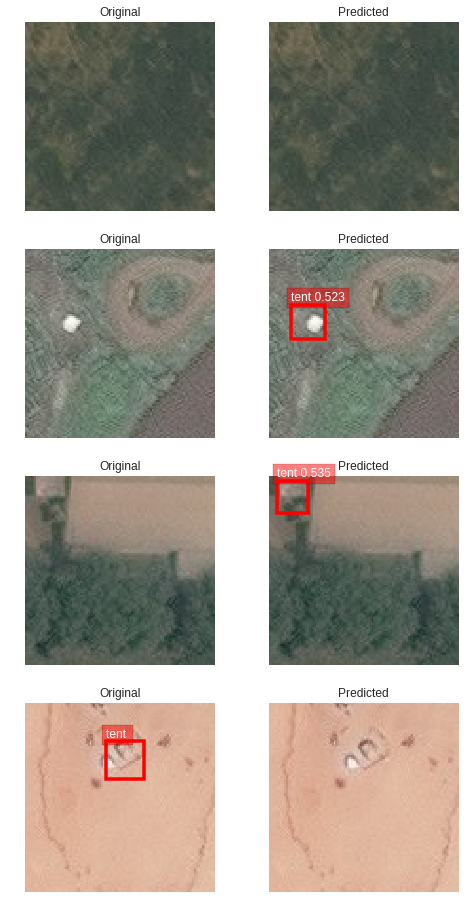

In [81]:
show_examples(net, test_dataset, fn=filter_and_merge_fn(0.5, 0.3),
              num_examples=4, threshold=0.5)

## Label Examples

In [0]:
def get_rating_examples(dataset, indices, fn=lambda x,y,z:(x[0],y[0],z[0])):
  """
  This function will iterate through a series of input questions that take
  examples from a dataset (defined by the indices argument). The input questions
  will plot:
    1) the original image
    2) the image with labeled bounding boxes
    3) the image with predicted bounding boxes
    (Note that 2-3 will be switched 50% of the time in ordering)
  and will ask:
    1) number of tents counted
    2-3) number of tents covered by boxes (x 2 candidates)
    4-5) number of boxes covering tents (x 2 candidates)
    6) confirmation (triggers questions again on 'n')
  Note that for 1-5, inputs that are not integers and/or outside the valid
  ranges will trigger the question to be asked until a valid answer is given.
  The final question is a confirmation question. If the user input is 'n,' the
  entire series of questions will be repeated.
  """
  assert max(indices) <= len(dataset), ("Cannot have an index that is larger ",
                                        "than the dataset size!")
  num_examples = len(indices)
  total_counts = np.zeros(num_examples)
  counts = np.zeros((num_examples, 2, 3))
  
  def confirm_int(x):
    try:
      val = int(x)
    except ValueError:
      return False
    return True
  
  for i in range(num_examples):
    print("Example %d" % i)
    fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
    image, label = dataset[indices[i]]
    
    # Get model predictions
    x, image = gcv.data.transforms.presets.ssd.transform_test(image, IM_SIZE)
    cid, score, bbox = net(x)
    if fn is not None:
      bbox, score, cid = fn(bbox, score, cid)
      
    # Fill out counts for boxes on tomnod and model prediction
    counts[i, 0, 0] = label.shape[0]
    counts[i, 1, 0] = score.shape[0]

    tomnod_idx, model_idx = 0, 1
    if np.random.rand() > 0.5:
      tomnod_idx, model_idx = 1, 0

    _ = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5],
                      class_names=classes, ax=axes[tomnod_idx+1])
    _ = viz.plot_bbox(image, bboxes=bbox, labels=cid, class_names=classes,
                      ax=axes[model_idx+1])
    
    axes[0].axis('off')
    axes[0].imshow(image)
    axes[0].title.set_text('Original')
    axes[1].axis('off')
    axes[1].title.set_text('Candidate 1')
    axes[2].axis('off')
    axes[2].title.set_text('Candidate 2')
    plt.show()
    
    # If candidate 1 is tomnod, then we want to insert at index 0
    # If candidate 1 is from the model, we want to insert at index 1
    # Tomnod_idx = 0 when candidate 1 is tomnod
    # Tomnod_idx = 1 when candidate 1 is the model (and candidate 2 is tomnod)
    
    # Ask questions until redo is False
    redo = True
    while(redo):
      # Question 1
      x = input('How many tents do you count?')
      while not confirm_int(x):
        print("Answer needs to be an integer! Try again ...")
        x = input('How many tents do you count?')
      total_counts[i] = x
      # Question 2
      x = input('How many tents are covered by boxes in Candidate 1 (out of %d)?' % total_counts[i])
      while not confirm_int(x) or int(x) > int(total_counts[i]):
        print("Answer needs to be an integer between 0 and %d! Try again..." % total_counts[i])
        x = input('How many tents are covered by boxes in Candidate 1 (out of %d)?' % total_counts[i])
      counts[i, tomnod_idx, 1] = x
      # Question 3
      x = input('How many tents are covered by boxes in Candidate 2 (out of %d)?' % total_counts[i])
      while not confirm_int(x) or int(x) > int(total_counts[i]):
        print("Answer needs to be an integer between 0 and %d! Try again..." % total_counts[i])
        x = input('How many tents are covered by boxes in Candidate 2 (out of %d)?' % total_counts[i])
      counts[i, model_idx, 1] = x
      # Question 4
      x = input('How many boxes are covering tents in Candidate 1 (out of %d)?' % counts[i, tomnod_idx, 0])
      while not confirm_int(x) or int(x) > int(counts[i, tomnod_idx, 0]):
        print("Answer needs to be an integer between 0 and %d! Try again..." % counts[i, tomnod_idx, 0])
        x = input('How many boxes are covering tents in Candidate 1 (out of %d)?' % counts[i, tomnod_idx, 0])
      counts[i, tomnod_idx, 2] = x
      # Question 3
      x = input('How many boxes are covering tents in Candidate 2 (out of %d)?' % counts[i, model_idx, 0])
      while not confirm_int(x) or int(x) > int(counts[i, model_idx, 0]):
        print("Answer needs to be an integer between 0 and %d! Try again..." % counts[i, model_idx, 0])
        x = input('How many boxes are covering tents in Candidate 2 (out of %d)?' % counts[i, model_idx, 0])
      counts[i, model_idx, 2] = x
      # Chance to redo
      redo = (input('Confirm? (if you type \'n\' it will redo the question process)') == 'n')
    
  # Fill out the rest of the information from here
  return total_counts, counts

Example 0


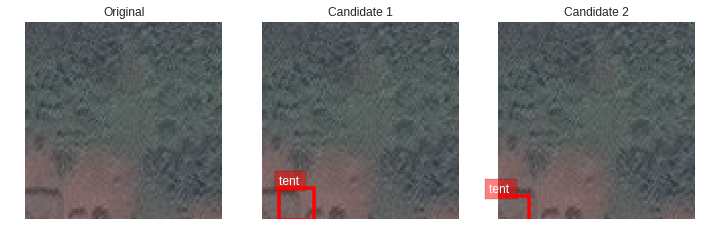

How many tents do you count?1
How many tents are covered by boxes in Candidate 1 (out of 1)?1
How many tents are covered by boxes in Candidate 2 (out of 1)?1
How many boxes are covering tents in Candidate 1 (out of 1)?1
How many boxes are covering tents in Candidate 2 (out of 1)?1
Confirm? (if you type 'n' it will redo the question process)y
Example 1


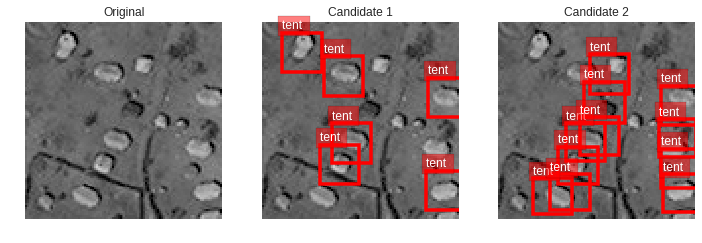

How many tents do you count?15
How many tents are covered by boxes in Candidate 1 (out of 15)?6
How many tents are covered by boxes in Candidate 2 (out of 15)?8
How many boxes are covering tents in Candidate 1 (out of 6)?6
How many boxes are covering tents in Candidate 2 (out of 11)?11
Confirm? (if you type 'n' it will redo the question process)y
Example 2


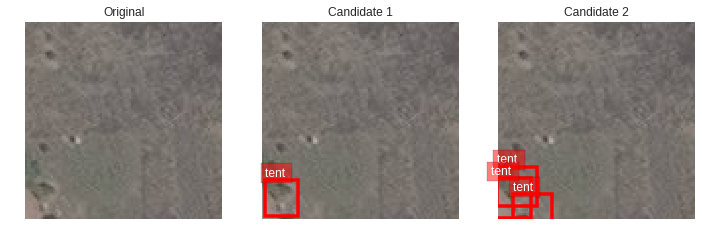

How many tents do you count?1
How many tents are covered by boxes in Candidate 1 (out of 1)?1
How many tents are covered by boxes in Candidate 2 (out of 1)?1
How many boxes are covering tents in Candidate 1 (out of 1)?1
How many boxes are covering tents in Candidate 2 (out of 3)?2
Confirm? (if you type 'n' it will redo the question process)y
Example 3


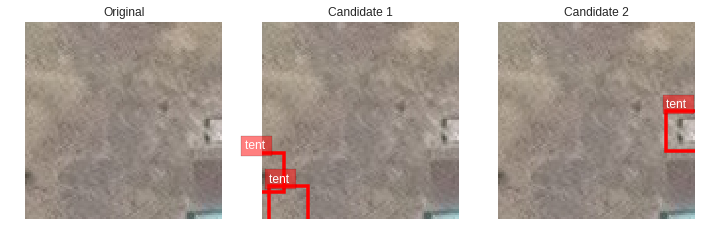

How many tents do you count?2
How many tents are covered by boxes in Candidate 1 (out of 2)?1
How many tents are covered by boxes in Candidate 2 (out of 2)?1
How many boxes are covering tents in Candidate 1 (out of 2)?1
How many boxes are covering tents in Candidate 2 (out of 1)?1
Confirm? (if you type 'n' it will redo the question process)y
Example 4


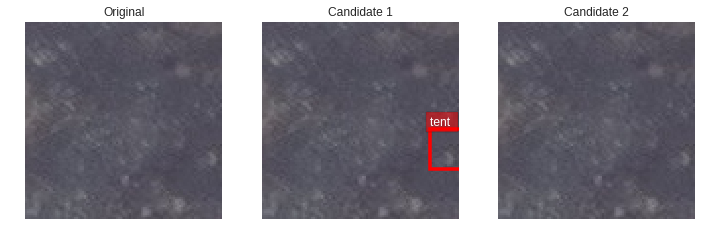

How many tents do you count?0
How many tents are covered by boxes in Candidate 1 (out of 0)?0
How many tents are covered by boxes in Candidate 2 (out of 0)?0
How many boxes are covering tents in Candidate 1 (out of 1)?0
How many boxes are covering tents in Candidate 2 (out of 0)?0
Confirm? (if you type 'n' it will redo the question process)y


In [0]:
# Recap: filter_and_merge_fn has the first number as the threshold for the score
# and the second as the min IOU necessary to merge two boxes together

# Uncomment for final evaluation with 100 examples per group member
# emma_indices = range(100)
# dan_indices = range(100, 200)
# robert_indices = range(200, 300)
# total, counts = get_rating_examples(test_dataset, emma_indices,
#                                     num_examples=100,
#                                     fn=filter_and_merge_fn(0.5, 0.9))

# Example rating shown below
total, counts = get_rating_examples(test_dataset,
                                    np.random.choice(range(len(test_dataset)), 5),
                                    fn=filter_and_merge_fn(0.5, 0.9))

In [0]:
# REPLACE WITH YOUR NAME!
filename = "<name>_ratings.p"

# Save your ratings!
blob = bucket.blob('groundtruth_eval/%s/%s/%s' % (REGION, MODEL, filename))
pickle.dump([total, counts], open(filename, "wb"))
blob.upload_from_filename(filename)

In [0]:
# Open from google bucket
blob = bucket.blob('groundtruth_eval/%s/%s/%s' % (REGION, MODEL, filename))
with open('tmp.p', 'wb') as obj:
  blob.download_to_file(obj)
total, counts = pickle.load(open('tmp.p', "rb"))

## Aggregate Groundtruths

In [0]:
FILES = ['emma_ratings.p', 'dan_ratings.p', 'robert_ratings.p']
MODEL = 'ssd_512_resnet50_v1_voc'

In [0]:
def rmse(pred, true):
  return np.sqrt(np.mean((pred-true)**2))

In [0]:
def print_eval(total, counts):
  non_zeros = np.array([i for i in range(len(total)) if total[i] > 0])
  
  tomnod_count, tomnod_tp, tomnod_fp = counts[non_zeros,0,0], counts[non_zeros,0,1], counts[non_zeros,0,0]-counts[non_zeros,0,2]
  model_count, model_tp, model_fp = counts[non_zeros,1,0], counts[non_zeros,1,1], counts[non_zeros,1,0]-counts[non_zeros,1,2]
  
  # Recall / TPR / Sensitivity is the number of tents covered by boxes / number of total tents identified
  tomnod_recall = np.mean(tomnod_tp/np.maximum(total[non_zeros].astype(np.float32), 1e-8))
  model_recall = np.mean(model_tp/np.maximum(total[non_zeros].astype(np.float32), 1e-8))
  
  # Precision is TP/(TP + FP)
  tomnod_pre = np.mean(tomnod_tp/np.maximum(tomnod_tp+tomnod_fp, 1e-8))
  model_pre = np.mean(model_tp/np.maximum(model_tp+model_fp, 1e-8))

  print("N = %d" % total.shape[0])
  print("RATING\t precision\t recall\t\t F1")
  print("TOMNOD\t %0.4f\t\t %0.4f\t\t %0.4f" % (tomnod_pre, tomnod_recall, 2*tomnod_pre*tomnod_recall/(tomnod_pre+tomnod_recall)))
  print("MODEL\t %0.4f\t\t %0.4f\t\t %0.4f" % (model_pre, model_recall, 2*model_pre*model_recall/(model_pre+model_recall)))

In [0]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

def show_correlations(total, counts, text=(0.1, 0.95)):
  from scipy.stats import linregress

  # Correlation between predicted counts / actual counts for TomNod/Model
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))
  
  xmax = int(np.max(counts))
  ymax = int(np.max(total))
  all_max = max(xmax, ymax)
  xrange=np.asarray(range(all_max))

  reg = linregress(counts[:,0,0], total)
  rmse_tomnod = rmse(counts[:,0,0], total)
  axes[0].plot(counts[:,0,0], total, 'k.')
  axes[0].plot(xrange, xrange*reg.slope + reg.intercept, 'r-')
  axes[0].set_title('Tomnod')
  axes[0].set_xlabel('Tomnod Count')
  axes[0].set_ylabel('Groundtruth Count')
  axes[0].set_xlim(0, all_max)
  axes[0].set_ylim(0, all_max)
  axes[0].text(all_max*text[0], all_max*text[1], '$R^2$ = {0:0.03f}.\nRMSE = {1:0.03f}'.format(reg.rvalue, rmse_tomnod),
               verticalalignment='top')

  reg = linregress(counts[:,1,0], total)
  rmse_model = rmse(counts[:,1,0], total)
  axes[1].plot(counts[:,1,0], total, 'k.')
  axes[1].plot(xrange, xrange*reg.slope + reg.intercept, 'r-')
  axes[1].set_title('Detection Model')
  axes[1].set_xlabel('Detection Model Count')
  axes[1].set_ylabel('Groundtruth Count')
  axes[1].set_xlim(0, all_max)
  axes[1].set_ylim(0, all_max)
  axes[1].text(all_max*text[0], all_max*text[1], '$R^2$ = {0:0.03f}.\nRMSE = {1:0.03f}'.format(reg.rvalue, rmse_model),
               verticalalignment='top')
  
  plt.show()

### Africa1

In [0]:
REGION = 'Africa1'
total = np.zeros(0)
counts = np.zeros((0, 2, 3))
for filename in FILES:
  blob = bucket.blob('groundtruth_eval/%s/%s/%s' % (REGION, MODEL, filename))
  with open('tmp.p', 'wb') as obj:
    blob.download_to_file(obj)
  t, c = pickle.load(open('tmp.p', "rb"))
  total = np.concatenate([total, t])
  counts = np.concatenate([counts, c])

In [270]:
print_eval(total, counts)

N = 300
RATING	 precision	 recall		 F1
TOMNOD	 0.6043		 0.4401		 0.5093
MODEL	 0.9023		 0.8827		 0.8924


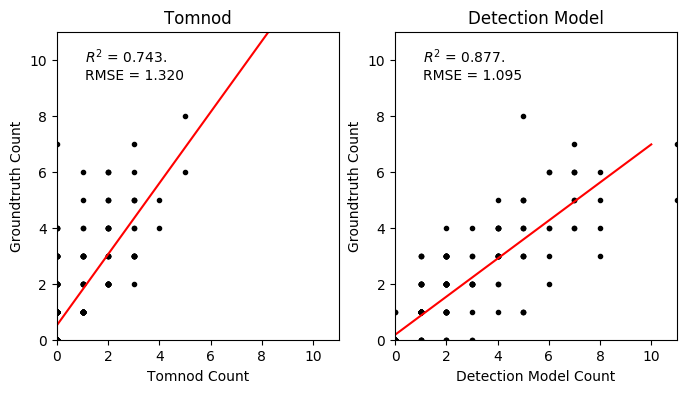

In [271]:
show_correlations(total, counts)

### Africa2

In [0]:
REGION = 'Africa2'
total = np.zeros(0)
counts = np.zeros((0, 2, 3))
for filename in FILES:
  blob = bucket.blob('groundtruth_eval/%s/%s/%s' % (REGION, MODEL, filename))
  with open('tmp.p', 'wb') as obj:
    blob.download_to_file(obj)
  t, c = pickle.load(open('tmp.p', "rb"))
  total = np.concatenate([total, t])
  counts = np.concatenate([counts, c])

In [273]:
print_eval(total, counts)

N = 300
RATING	 precision	 recall		 F1
TOMNOD	 0.2614		 0.1380		 0.1807
MODEL	 0.7287		 0.4409		 0.5494


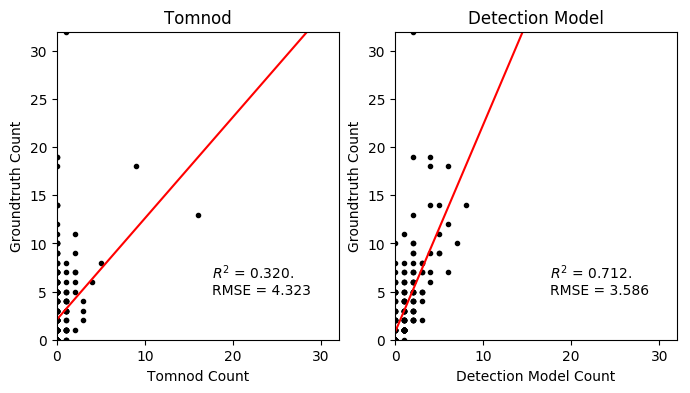

In [274]:
show_correlations(total, counts, text=(0.55, 0.25))

### WesternAsia

In [0]:
REGION = 'WesternAsia'
total = np.zeros(0)
counts = np.zeros((0, 2, 3))
for filename in FILES:
  blob = bucket.blob('groundtruth_eval/%s/%s/%s' % (REGION, MODEL, filename))
  with open('tmp.p', 'wb') as obj:
    blob.download_to_file(obj)
  t, c = pickle.load(open('tmp.p', "rb"))
  total = np.concatenate([total, t])
  counts = np.concatenate([counts, c])

In [276]:
print_eval(total, counts)

N = 300
RATING	 precision	 recall		 F1
TOMNOD	 0.4497		 0.3211		 0.3747
MODEL	 0.9182		 0.8524		 0.8841


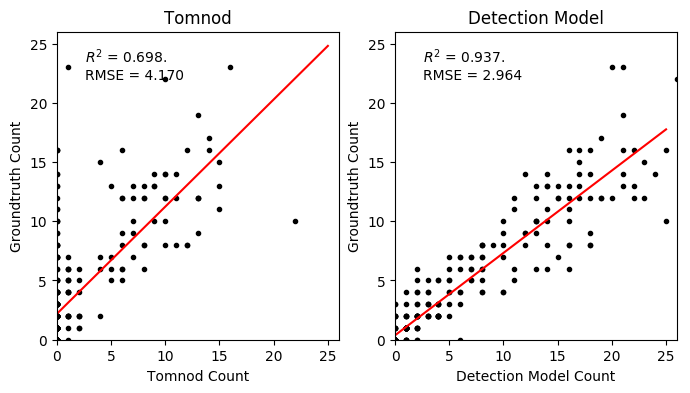

In [277]:
show_correlations(total, counts)